#Image Generation and Background Replacement using Stable Diffusion
##(Solution Assignment)

**Author:** Atharva Abhijit Golwalkar

**Date:** 20th Decembe 2024


# **1.Title and Introduction**

This project demonstrates an automated pipeline for generating masks and replacing objects in images using state-of-the-art AI models. The workflow leverages the following:


*  CLIPSeg: A segmentation model to identify and mask objects in images based on textual prompts
* Stable Diffusion: A generative AI model used for inpainting, enabling the replacement of masked objects with realistic alternatives guided by text prompts.

The primary goal is to simplify object manipulation in images without manual intervention, making it highly applicable in design, marketing, and media editing.

## Overview of the Workflow
The project involves the following steps:  
1. **Device Setup**  
   - Check and configure the environment (CPU/GPU) for optimal performance.  

2. **Loading Pre-trained Models**  
   - **CLIPSeg**: For segmentation and mask generation using text prompts.  
   - **Stable Diffusion**: For image inpainting and object replacement.  

3. **Image Preparation**  
   - Load images either from a local directory or a URL.  
   - Resize and preprocess the image while maintaining its aspect ratio.  

4. **Mask Generation**  
   - Use the CLIPSeg model to generate a binary mask that highlights the object to be replaced based on the text prompt.  

5. **Object Replacement**  
   - Utilize Stable Diffusion's inpainting capabilities to replace the masked object with a new object as described in the replacement prompt.  

6. **Visualization**  
   - Display the original image, the generated mask, and the final output image for comparison.  

This workflow ensures a seamless transition from object detection to replacement with minimal manual intervention.  


## Installation and Dependencies

To execute this notebook, ensure that the required libraries and models are installed. Below is a list of key dependencies:

### Python Libraries:
- `torch`: For running deep learning models.
- `diffusers`: For working with Stable Diffusion pipelines.
- `transformers`: For CLIPSeg processing.
- `Pillow (PIL)`: For image manipulation.
- `matplotlib`: For visualizing images.
- `requests`: For downloading images from URLs.

### Setup:
Run the following cell to install the required packages if not already installed:


In [ ]:
!pip install torch torchvision diffusers transformers Pillow matplotlib requests

Purpose of Libraries:

  

* torch: Provides tensor operations and model execution for deep learning tasks.

* diffusers: Loads and runs Stable Diffusion models for image generation and inpainting.

* AutoPipelineForInpainting: Inpainting pipeline from diffusers to modify image content.

*     CLIPSegProcessor, CLIPSegForImageSegmentation: Used for image segmentation based on textual prompts.

*    PIL: Handles image opening, manipulation, and saving.

*     numpy: Used for handling and processing image masks (arrays).

*     matplotlib.pyplot: Visualizes images (original, mask, and generated).

*    requests: Downloads images from URLs.

*   BytesIO: Reads image data from memory for processing.




   

In [ ]:


import torch
import diffusers
from diffusers import AutoPipelineForInpainting
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import requests
from io import BytesIO


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]



  ### Device Setup:

   Checks if CUDA (GPU) is available, but forces usage of CPU for computations. Prints the current device.


### load_image() function:

1.    Loads an image from a provided file path or URL.

2.    Converts the image to RGB format if necessary.
3.    Resizes the image while maintaining the aspect ratio.

4.    Pads the image to fit the target size if needed.



      
        
      

In [ ]:

# Check if CUDA is available and set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

# Function to load and prepare image
def load_image(image_path, target_size=(512, 512)):
    """
    Load and preprocess image from path or URL
    Args:
        image_path: Path or URL to image
        target_size: Desired size for processing
    Returns:
        PIL Image object
    """
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)

    # Convert to RGB if necessary
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize while maintaining aspect ratio
    image.thumbnail(target_size)

    # Create new image with padding if needed
    new_image = Image.new('RGB', target_size, (255, 255, 255))
    new_image.paste(image, ((target_size[0] - image.size[0]) // 2,
                           (target_size[1] - image.size[1]) // 2))

    return new_image

Using device: cpu



##Generate_mask

###  1. Image Resizing:
  The input image is resized to 352x352 to be compatible with the CLIPSeg model.

 ### 2. Inputs for CLIPSeg:
  processor prepares inputs by processing the image and prompt.
  model generates the mask using the image and prompt.

 ### 3.  Sigmoid Activation and Mask Generation:
  Raw model outputs are passed through a sigmoid function to generate mask predictions.
  The mask is converted into a binary format using a threshold (values greater than 0.5 are set to 1, others to 0).

### 4.  Visualization:
  Images of the input, raw mask, and binary mask are displayed side-by-side for visual analysis.

### 5.  Finalizing the Mask:
  A PIL Image of the binary mask is resized to the original image size (512x512).
  The mask is normalized to have pixel values between 0 and 1 for compatibility with other image processing steps.



In [ ]:

def generate_mask(image, prompt, processor, model):
    """
    Generate mask automatically using CLIPSeg
    Args:
        image: PIL Image
        prompt: Text prompt describing object to mask
        processor: CLIPSeg processor
        model: CLIPSeg model
    Returns:
        Binary mask as numpy array
    """
    # Resize the image to 352x352 (required by CLIPSeg)
    image = image.resize((352, 352))


    # Prepare inputs
    inputs = processor(images=image, text=[prompt], padding="max_length", return_tensors="pt")

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate mask
    with torch.no_grad():
        outputs = model(**inputs)

        # Debug: Print shape at each step
        print(f"Raw outputs shape: {outputs.logits.shape}")

        preds = outputs.logits.sigmoid()
        print(f"Predictions shape: {preds.shape}")


    # Convert predictions to numpy and ensure proper dimensions
    mask = preds[0].cpu().numpy()  # Shape should be (352, 352)

    print(f"Initial mask shape: {mask.shape}")


    # Apply threshold
    binary_mask = (mask > 0.5).astype(np.float32)
    print(f"Binary mask shape: {binary_mask.shape}")

    # Create visualization
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Raw Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Mask")
    plt.axis('off')

    plt.show()

    # Create PIL Image from mask for resizing
    mask_image = Image.fromarray((binary_mask * 255).astype(np.uint8))

    # Resize mask to match original image size
    mask_image = mask_image.resize((512,512), Image.LANCZOS)

 # Convert back to numpy array and normalize
    final_mask = np.array(mask_image) / 255.0


    return final_mask

##Replace_object

###1. Mask Conversion:

  The input mask is checked and converted into a proper format (PIL Image if not already).
  If the mask is in numpy.ndarray format, it's converted to a PIL Image and adjusted for use in the Stable Diffusion pipeline.

###2. Debugging Visualization:

  The mask is visualized for debugging purposes before inpainting, allowing the user to confirm the correct mask is being applied.

###3. Image and Mask Preparation:

  Both the original image and the mask are resized to 512x512 to match the expected input size for the Stable Diffusion pipeline.

###4. Stable Diffusion Inpainting:

  The function uses the pipeline to generate the inpainted image by providing the original image, mask, prompt, and optional negative prompt.
  Several parameters control the generation process, including num_inference_steps, guidance_scale, and strength.

###5. Returned Output:

  The output is the image generated by the pipeline, with the object replaced as specified by the prompt.

In [ ]:

# Update the replace_object function to ensure proper mask handling
def replace_object(original_image, mask, pipeline, prompt, negative_prompt=None):
    """
    Replace object in image using Stable Diffusion
    Args:
        original_image: PIL Image
        mask: Binary mask array
        pipeline: Stable Diffusion pipeline
        prompt: Text prompt for replacement
        negative_prompt: Optional negative prompt
    Returns:
        Generated image with replaced object
    """
    # Ensure mask is in correct format
    if isinstance(mask, np.ndarray):
        mask_image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
    else:
        mask_image = mask

    # Debug: Show mask being used
    plt.figure(figsize=(5, 5))
    plt.imshow(mask_image, cmap='gray')
    plt.title("Mask Used for Inpainting")
    plt.axis('off')
    plt.show()

    # Prepare inputs
    init_image = original_image.resize((512, 512))
    mask_image = mask_image.resize((512, 512))

    # Generate image
    output = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=init_image,
        mask_image=mask_image,
        num_inference_steps=4,
        guidance_scale=1.5,
        strength=0.99,
    ).images[0]

    return output


## Main function

###1. Model Loading:

  CLIPSeg is loaded for automatic object masking, which uses a pre-trained model for segmentation.
  Stable Diffusion pipeline (Flux) is initialized for inpainting, which will replace objects in the image.

###2. Image Loading:

  A test image is loaded from a URL. You can replace the image_path with any valid URL or local file path.

###3. Mask Generation:

  A mask is automatically generated using CLIPSeg, based on a text prompt (e.g., "sitting cat"). The mask identifies the object to be replaced in the image.
  Error handling is implemented to catch potential issues during mask generation.

###4. Object Replacement:

  The replace_object() function is called to replace the masked object with a new one based on a replacement prompt (e.g., "golden retriever dog sitting on a bench").
  An optional negative prompt can be used to refine the inpainting process and avoid undesired elements.

###5. Result Visualization:

  The original image, the generated mask, and the resulting image with the replaced object are displayed side by side for comparison.

###6. Execution Flow:

  The main() function executes the full pipeline: loading models, generating a mask, replacing an object, and displaying results.

Loading models...
Processor loaded: True
Segmentation model loaded: True


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading image...
Generating mask...


/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Raw outputs shape: torch.Size([1, 352, 352])
Predictions shape: torch.Size([1, 352, 352])
Initial mask shape: (352, 352)
Binary mask shape: (352, 352)


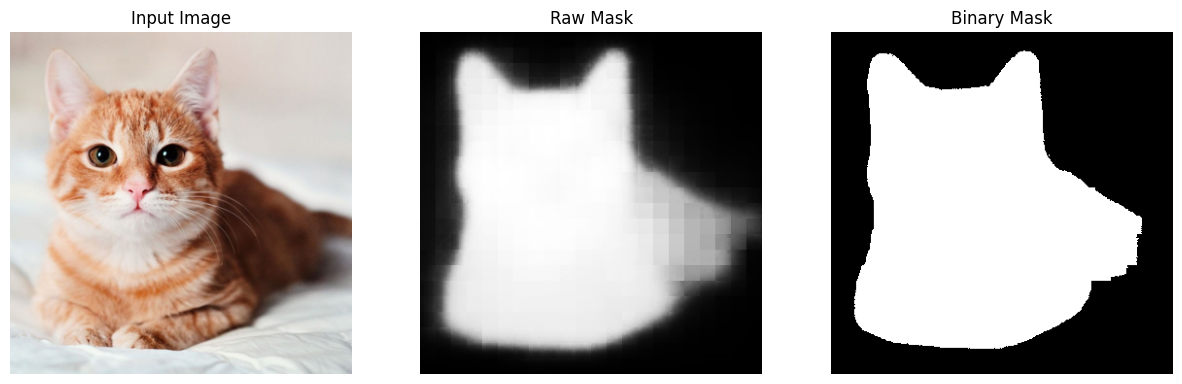

Generated mask shape: (512, 512)
Generated mask dtype: float64
Replacing object...


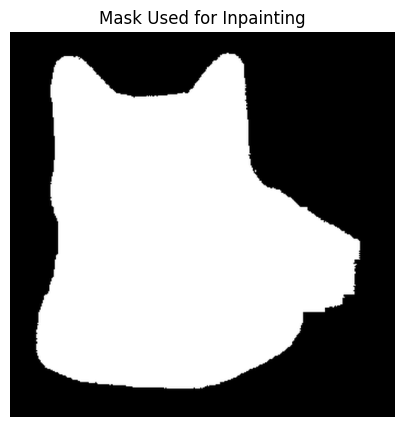

  0%|          | 0/3 [00:00<?, ?it/s]

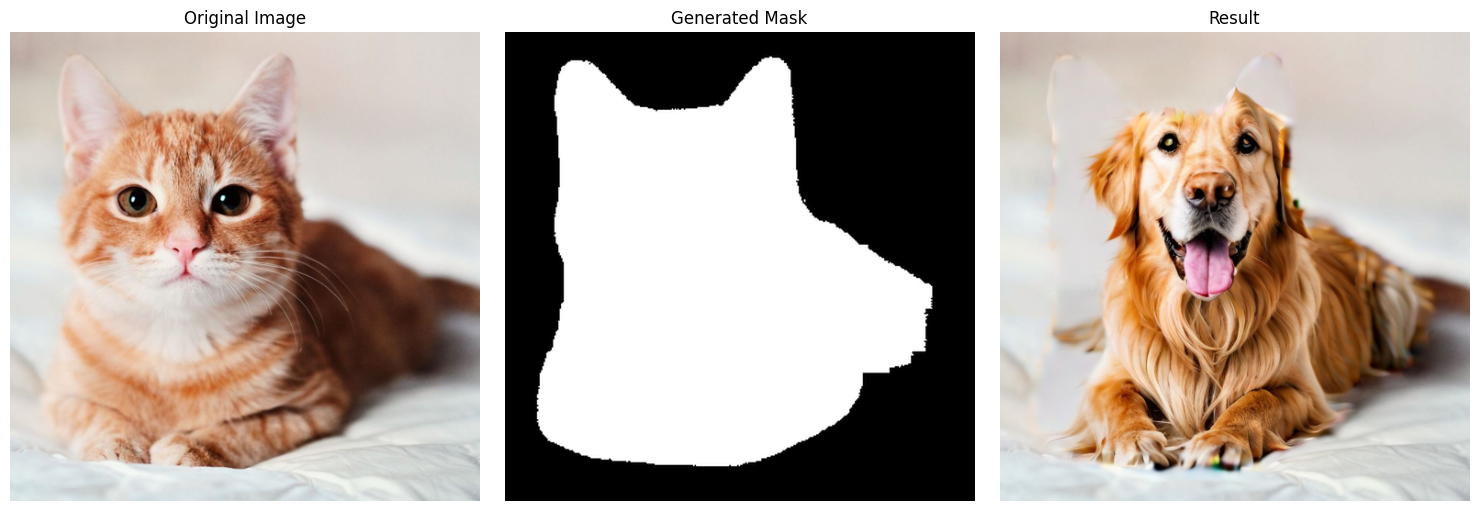

In [ ]:

# Main execution
def main():
    # 1. Load Models
    print("Loading models...")

    # Load CLIPSeg for automatic masking
    processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
    seg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
    seg_model.to(device)

     # Debug: Print model info
    print("Processor loaded:", processor is not None)
    print("Segmentation model loaded:", seg_model is not None)

    # Load Stable Diffusion pipeline (using Flux)
    model_id = "stabilityai/sdxl-turbo"
    # pipeline = AutoPipelineForInpainting.from_pretrained(
    #     model_id,
    #     torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    #     variant="fp16" if torch.cuda.is_available() else None
    # )
    pipeline = AutoPipelineForInpainting.from_pretrained(
        model_id,torch_dtype=torch.float32
    )
    pipeline.to(device)

    # 2. Load test image
    print("Loading image...")
    # image_path = "https://replicate.delivery/pbxt/xs0pPOUM6HKmPlJJBXqKfE1YsiMzgNsCuGedlX0VqvPYifLgA/out-0.png"
    image_path = "https://storage.googleapis.com/kaggle-datasets-images/4722249/8015245/737ab81969b3ce8dee6e4e578cfcb7f7/dataset-card.jpg?t=2024-04-21-09-20-50"
    original_image = load_image(image_path)

    # 3. Generate mask
    print("Generating mask...")
    mask_prompt = "sitting cat"  # Replace with desired object to mask

    try:
        mask = generate_mask(original_image, mask_prompt, processor, seg_model)
        print(f"Generated mask shape: {mask.shape}")
        print(f"Generated mask dtype: {mask.dtype}")
    except Exception as e:
        print(f"Error in mask generation: {str(e)}")
        print(f"Error type: {type(e)}")
        import traceback
        traceback.print_exc()
        return

    # 4. Replace object
    print("Replacing object...")
    replacement_prompt = "a beautiful golden retriever dog alert and looking upright , facing forward, candid pet photography, high quality"
    negative_prompt = "blurry, distorted, deformed, unrealistic, bad anatomy, wrong pose, multiple animals, cartoonish, tilted, sideways, poor detatils"
    result_image = replace_object(original_image, mask, pipeline, replacement_prompt, negative_prompt)
    # replacement_prompt = """a photorealistic golden retriever dog sitting alert and upright on a bench,
    #     crystal clear face with detailed features, sharp focused eyes, distinct nose,
    #     well-defined fur texture, natural outdoor lighting, high resolution photograph,
    #     professional pet photography, 8k quality, ultra detailed, masterful composition"""

    # negative_prompt = """blurry, low quality, distorted, deformed, unrealistic, bad anatomy,
    #     wrong proportions, multiple animals, cartoonish, tilted, sideways, poor details,
    #     oversaturated, overexposed, bad lighting, artificial looking, soft focus,
    #     out of focus, pixelated, noisy, grainy"""
    # result_image = replace_object(original_image, mask, pipeline, replacement_prompt, negative_prompt)

    # 5. Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Generated Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_image)
    plt.title("Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
